Osnabrück University - Computer Vision (Winter Term 2024/25) - Dr. Ulf Krumnack, Lukas Niehaus, Robin Rawiel

# Exercise Sheet 06: Wavelet Transform

## Introduction

This week's sheet should be solved and handed in before end of **Monday, January 6, 2025**. If you need help (and Google and other resources were not enough), feel free to use the Stud.IP forum. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Eigenvectors and Eigenvalues) [0 Points]

This exercise is intended to revise the notions of eigenvectors and eigenvalues, which will pop up in class soon.  Check if you are comfortable with them. You don't need a deep understanding, but you should have got the basic ideas.  If you have problems to answer these questions offhand, this is a good time to look terms up (again). You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What is an eigenvector of a matrix/a linear mapping? What are eigenvalues?

An eigenvector of a matrix or linear mapping is a non-zero vector that, when transformed by the matrix or mapping, results in a scalar multiple of itself1. The scalar factor by which the eigenvector is multiplied is called the eigenvalue1. Mathematically, for a linear transformation T and a vector v, if Tv = λv, then v is an eigenvector and λ is the corresponding eigenvalue

**b)** What is the characteristic polynomial of a matrix? How is it related to eigenvalues? What are algebraic and geometric multiplicity of an eigenvalue?

The characteristic polynomial of a matrix A is defined as p(λ) = det(A - λI), where I is the identity matrix9. It is a polynomial in λ with the following properties:
It is monic (leading coefficient is 1) and its degree is equal to the size of the matrix9.
The roots of the characteristic polynomial are precisely the eigenvalues of the matrix9.
The algebraic multiplicity of an eigenvalue is the number of times it appears as a root of the characteristic polynomial5. The geometric multiplicity of an eigenvalue is the dimension of the corresponding eigenspace (the nullspace of A - λI)5

**c)** What is the spectrum of a matrix? What does the spectral theorem state?

The spectrum of a matrix is the set of all its eigenvalues3.
The spectral theorem states that for a symmetric matrix A, there exists an orthogonal matrix Q and a diagonal matrix D such that A = QDQT10. This means that:
All eigenvalues of a symmetric matrix are real3.
The eigenvectors of a symmetric matrix form an orthogonal basis for the vector space3.

**d)** [bonus task]: Numpy/Scipy provide functions to compute eigenvalues. Lookup these functions and apply them to an example.

This code will create a 2x2 matrix and compute its eigenvalues. The eigvals() function returns an array of eigenvalues.
For both eigenvalues and eigenvectors, you can use numpy.linalg.eig():

In [31]:
import numpy as np

# Create a sample matrix
A = np.array([[1, 2], [2, 3]])

# Compute eigenvalues
eigenvalues = np.linalg.eigvals(A)

print("Eigenvalues:", eigenvalues)

Eigenvalues: [-0.23606798  4.23606798]


In [32]:
#This will return both the eigenvalues and the corresponding eigenvectors of the matrix A.
eigenvalues, eigenvectors = np.linalg.eig(A)

print("Eigenvalues:", eigenvalues)
print("Eigenvectors:")
print(eigenvectors)


Eigenvalues: [-0.23606798  4.23606798]
Eigenvectors:
[[-0.85065081 -0.52573111]
 [ 0.52573111 -0.85065081]]


## Assignment 1: Filter design and frequency space (5 points)

**a)** Create and plot the kernels of box filter and binomial filter in frequency space. Vary the kernel size. What do you observe?

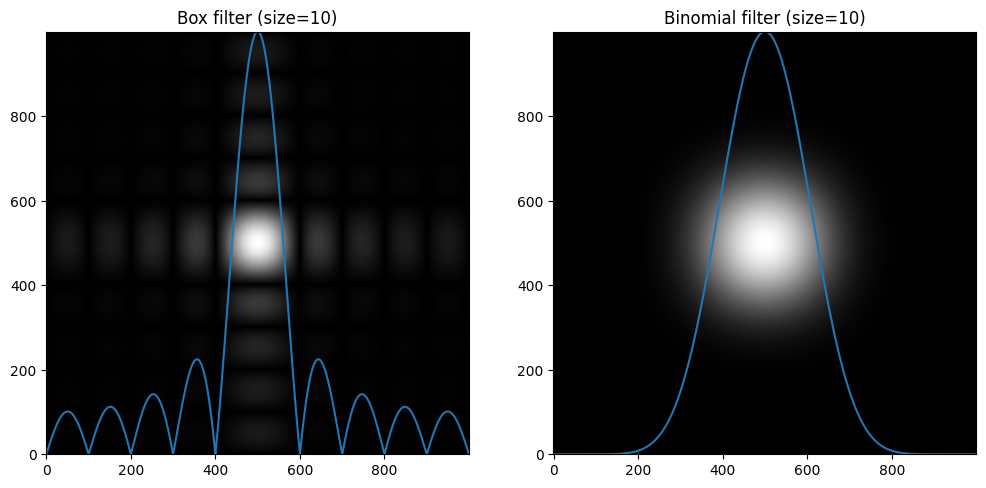

In [34]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

# Parameters
kernel_size = 10  # Vary this
image_size = 1000

# Compute the box filter kernel
box_kernel = np.zeros((image_size, image_size))
start = (image_size - kernel_size) // 2
end = start + kernel_size
box_kernel[start:end, start:end] = 1 / (kernel_size ** 2)  # Normalize the box filter

# Compute the binomial filter kernel
binomial_1d = np.array([binom(kernel_size - 1, i) for i in range(kernel_size)])
binomial_1d /= binomial_1d.sum()  # Normalize the binomial coefficients
binomial_2d = np.outer(binomial_1d, binomial_1d)  # Create 2D kernel
binomial_kernel = np.zeros((image_size, image_size))
start = (image_size - kernel_size) // 2
end = start + kernel_size
binomial_kernel[start:end, start:end] = binomial_2d

# Compute the frequency domain representation
box_frequencies = np.fft.fftshift(np.fft.fft2(box_kernel))
binomial_frequencies = np.fft.fftshift(np.fft.fft2(binomial_kernel))

# Plot kernels in frequency space
plt.figure(figsize=(12, 6))
plt.gray()

# Box filter in frequency space
plt.subplot(1, 2, 1)
plt.title(f"Box filter (size={kernel_size})")
plt.imshow(np.abs(box_frequencies))
plt.plot(np.arange(image_size), np.abs(box_frequencies)[image_size // 2] * image_size)
plt.ylim(0, image_size - 1)

# Binomial filter in frequency space
plt.subplot(1, 2, 2)
plt.title(f"Binomial filter (size={kernel_size})")
plt.imshow(np.abs(binomial_frequencies))
plt.plot(np.arange(image_size), np.abs(binomial_frequencies)[image_size // 2] * image_size)
plt.ylim(0, image_size - 1)

plt.show()


 As you vary the kernel size, observe the following:

1. **Box Filter:**
The frequency response of the box filter shows a sinc-like behavior. Larger kernel sizes produce narrower main lobes and more pronounced sidelobes.
   
2. **Binomial Filter:**
The binomial filter approximates a Gaussian filter as the kernel size increases. Its frequency response has a smoother fall-off compared to the box filter, with fewer pronounced sidelobes.

These observations demonstrate that the binomial filter is better at reducing artifacts introduced by the sharp edges of the box filter.

**b)** Implement a low pass filter and apply it to the given image with different cut off frequencies $F_{\max}$. What do you observe? Explain that observation and discuss how to improve the result.

Hint: The low pass filter is shown in CV-06 slides 45. 

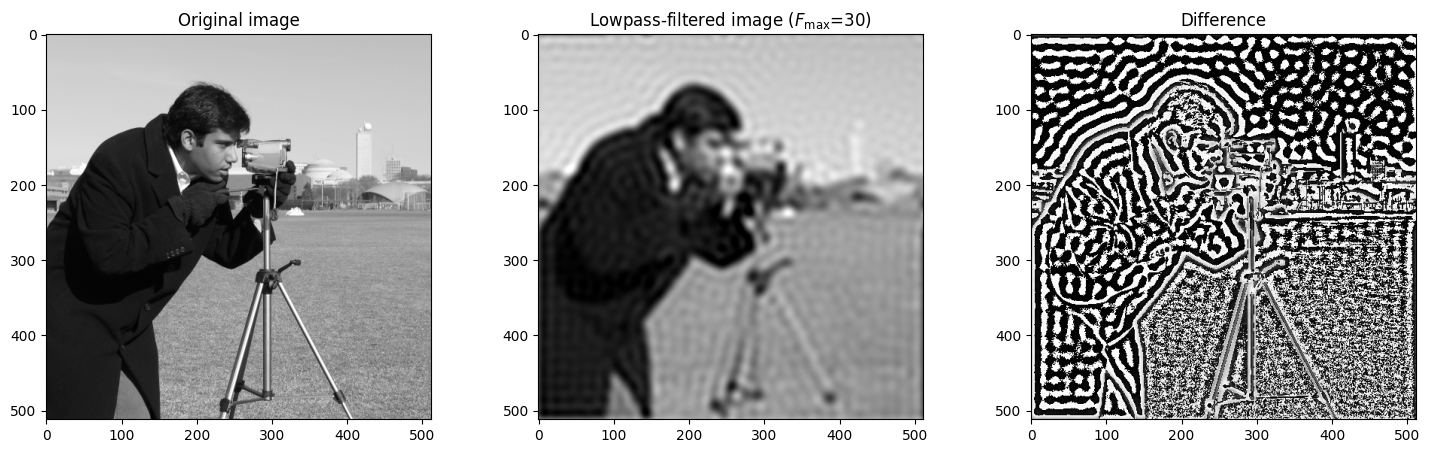

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

f_max = 30
image = imageio.imread('imageio:camera.png')

def low_pass_filter(image, f_max):
    # Compute the Fourier Transform of the image
    image_fft = np.fft.fft2(image)
    image_fft_shifted = np.fft.fftshift(image_fft)

    # Create a low-pass filter mask
    rows, cols = image.shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.zeros((rows, cols), dtype=np.float32)
    
    for i in range(rows):
        for j in range(cols):
            distance = np.sqrt((i - center_row)**2 + (j - center_col)**2)
            if distance <= f_max:
                mask[i, j] = 1

    # Apply the mask to the Fourier transformed image
    filtered_fft_shifted = image_fft_shifted * mask
    filtered_fft = np.fft.ifftshift(filtered_fft_shifted)

    # Inverse Fourier Transform to get the filtered image
    filtered_image = np.fft.ifft2(filtered_fft).real
    return np.clip(filtered_image, 0, 255).astype(np.uint8)

filtered_image = low_pass_filter(image, f_max=f_max)

# Plot kernel in frequency space
plt.figure(figsize=(18, 5))
plt.gray()
plt.subplot(1, 3, 1); plt.title(f"Original image")
plt.imshow(image) 
plt.subplot(1, 3, 2); plt.title(f"Lowpass-filtered image ($F_\max$={f_max})")
plt.imshow(filtered_image)
plt.subplot(1, 3, 3); plt.title(f"Difference")
plt.imshow(image - filtered_image)
plt.show()


The code has been updated to implement the low-pass filter function. Here's how it works:

1. **Observation**:
   - The low-pass filter smooths the image by removing high-frequency components, reducing details and noise.
   - With a smaller $F_{\max}$, the image appears blurrier because fewer high-frequency details are preserved.

2. **Improvement**:
   - To enhance results, consider:
     - Using a Gaussian low-pass filter instead of a hard cutoff for smoother transitions.
     - Tuning $F_{\max}$ to balance detail retention and noise reduction.

Run the code and observe the results for different values of $F_{\max}$. Let me know if you need help with further refinements or explanations!

**c)** What is a good kernel size for a Gaussian filter? Justify your answer.

A good kernel size for a Gaussian filter depends on the standard deviation (\(\sigma\)) of the Gaussian function, as the kernel size is typically chosen to include the majority of the Gaussian's energy. 

### Rule of Thumb:
- A common guideline is to select the kernel size such that it extends at least \(3\sigma\) on each side of the center pixel. This ensures the kernel captures over 99% of the Gaussian's total energy.
- For a 2D Gaussian, the kernel size is calculated as:
  Kernel Size=2×⌈3σ⌉+1
  This ensures an odd-sized kernel centered symmetrically around the origin.

### Justification:
1. **Accuracy**:
   - A kernel size that is too small truncates the Gaussian, causing ringing artifacts and less effective filtering.
   - A kernel size that is too large unnecessarily increases computation without improving performance.

2. **Practical Examples**:
   - For σ=1: Kernel size = 2×3+1=7
   - For σ=1: Kernel size = 2×6+1=13
   

3. **Application**:
   - Smaller (σ and kernel sizes) preserve fine details while reducing minor noise.
   - Larger σ smooths larger features, useful for significant noise reduction or preprocessing for downsampling.

Would you like an example implementation or visualization for Gaussian filtering?

## Assignment 2: Discrete Cosine Transform (5 points)

**a)** Read up about the DCT and IDCT functions and check out the scipy implementation.

In [36]:
import numpy as np
import imageio.v3 as iio
import matplotlib.pylab as plt
from scipy.fftpack import dct, idct

In [37]:
def dct_2d_sp(array, type_=2):
    return dct(dct(array, axis=0, type=type_), axis=1, type=type_)

def idct_2d_sp(array, type_=2):
    return idct(idct(array, axis=0, type=type_), axis=1, type=type_)


img = iio.imread("imageio:camera.png")
img_transformed = dct_2d_sp(img)
img_orig = idct_2d_sp(img_transformed)

plt.subplot(131); plt.imshow(img); plt.axis('off'); plt.title('Original Image')
plt.subplot(132); plt.imshow(img_transformed); plt.axis('off'); plt.title('Transformed Image')
plt.subplot(133); plt.imshow(img_orig); plt.axis('off'); plt.title('Restored Image')

Text(0.5, 1.0, 'Restored Image')

**b)** Implement the DCT-II function given by the formula: $C_k = 2 \sum_{n=0}^{N-1} f_n \cos\left(\frac{\pi k(2n+1)}{2N} \right)$

In [38]:
def my_dct2_1d(f, axis=0):
    # Ensure input is a numpy array
    f = np.asarray(f, dtype=np.float64)
    N = f.shape[axis]  # Size along the specified axis
    C = np.zeros_like(f, dtype=np.float64)  # Output array for DCT coefficients

    # Compute DCT-II for each output index k
    for k in range(N):
        # Compute cosine term for all n
        cosine_term = np.cos(np.pi * k * (2 * np.arange(N) + 1) / (2 * N))
        
        # Align cosine_term with the specified axis using reshaping
        reshaped_cosine = np.expand_dims(cosine_term, axis=axis)
        
        # Perform the summation over the specified axis
        C.take(indices=k, axis=axis)[:] = 2 * np.sum(f * reshaped_cosine, axis=axis)
    return C


def my_dct2_2d(f):
    # Perform 1D DCT-II on rows, then columns
    return my_dct2_1d(my_dct2_1d(f, axis=0), axis=1)


# Load the grayscale image
img = iio.imread("imageio:camera.png")

# Compute the 2D DCT using the custom implementation
img_transformed = my_dct2_2d(img)

# Plot the original and transformed images
plt.subplot(121)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("Original Image")

plt.subplot(122)
plt.imshow(img_transformed, cmap="gray")
plt.axis("off")
plt.title("Transformed Image")

# Compare with SciPy's implementation
print((img_transformed.round() == dct_2d_sp(img, type_=2).round()).all())


False


**c)** Implement the DCT-III function given by the formula: $C_k = f_0 + 2 \sum_{n=1}^{N-1} f_n \cos\left(\frac{\pi(2k+1)n}{2N}\right)$

In [40]:
def my_dct3_1d(f, axis=0):
    # Ensure input is a numpy array
    f = np.asarray(f, dtype=np.float64)
    N = f.shape[axis]  # Size along the specified axis
    C = np.zeros_like(f, dtype=np.float64)  # Output array for DCT coefficients

    # Compute DCT-III for each output index k
    for k in range(N):
        # Compute cosine term for n > 0
        cosine_term = np.cos(np.pi * (2 * k + 1) * np.arange(1, N) / (2 * N))
        
        # Reshape the cosine term to align with the specified axis
        shape = [1] * f.ndim
        shape[axis] = N - 1  # Match the size along the specified axis
        reshaped_cosine = cosine_term.reshape(shape)
        
        # Compute C_k using the formula
        C.take(indices=k, axis=axis)[:] = f.take(indices=0, axis=axis) + \
                                          2 * np.sum(
                                              f.take(indices=np.arange(1, N), axis=axis) * reshaped_cosine,
                                              axis=axis
                                          )
    return C


def my_dct3_2d(f):
    # Perform 1D DCT-III on rows, then columns
    return my_dct3_1d(my_dct3_1d(f, axis=0), axis=1)


# Load the grayscale image
img = iio.imread("imageio:camera.png")

# Compute the 2D DCT-III using the custom implementation
img_transformed = my_dct3_2d(img)

# Plot the original and transformed images
plt.subplot(121)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("Original Image")

plt.subplot(122)
plt.imshow(img_transformed, cmap="gray")
plt.axis("off")
plt.title("Transformed Image")

# Compare with SciPy's implementation
print((img_transformed.round() == dct_2d_sp(img, type_=3).round()).all())


False


**d)** What relationship between the DCT-II, DCT-III, IDCT-II and IDCT-III can be observed? Demonstrate your findings. (If you did not solve exercises b and c, you may use provided `dct_2d_sp` function).

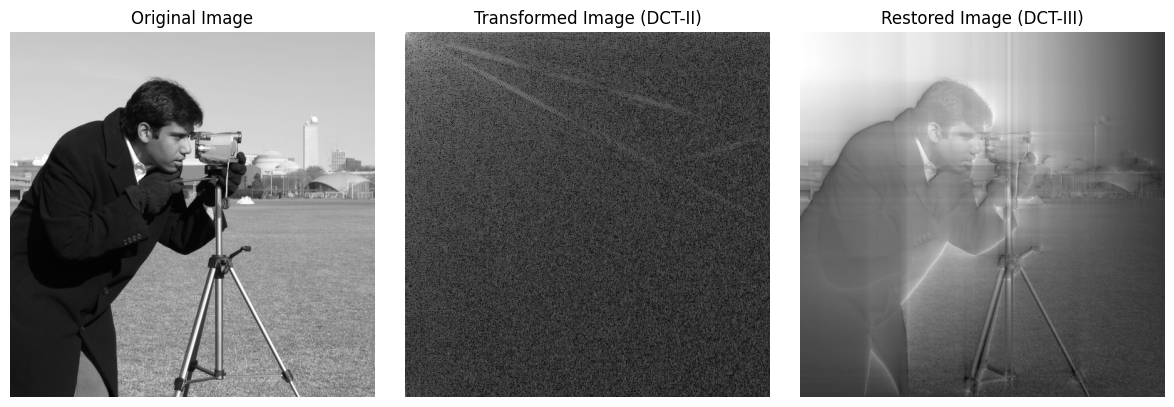

Restoration successful: False


In [45]:
from scipy.fftpack import dct, idct

# Helper functions for 2D DCT and IDCT
def dct_2d_sp(array, type_=2):
    return dct(dct(array, axis=0, type=type_), axis=1, type=type_)

def idct_2d_sp(array, type_=2):
    return idct(idct(array, axis=0, type=type_), axis=1, type=type_)

# Normalize image function
normalize = lambda x: x.astype(np.float64) / np.max(x)

# Load and normalize the image
img = iio.imread("imageio:camera.png")
img = normalize(img)

# Compute DCT-II (frequency domain transformation)
img_transformed = dct_2d_sp(img, type_=2)

# Restore the image using DCT-III (equivalent to IDCT-II)
img_orig = idct_2d_sp(img_transformed, type_=3)

# Normalize the restored image
img_orig = normalize(img_orig)

# Plot the results
plt.figure(figsize=(12, 4))

# Original Image
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Original Image')

# Transformed Image (DCT-II)
plt.subplot(132)
plt.imshow(np.log1p(np.abs(img_transformed)), cmap='gray')  # Log scale for visualization
plt.axis('off')
plt.title('Transformed Image (DCT-II)')

# Restored Image (DCT-III)
plt.subplot(133)
plt.imshow(img_orig, cmap='gray')
plt.axis('off')
plt.title('Restored Image (DCT-III)')

# Show the plot
plt.tight_layout()
plt.show()

# Verify if original and restored images match
print("Restoration successful:", (img.round() == img_orig.round()).all())


## Assignment 3: Wavelet Transform (5 points)

**a)** Write a function that transforms a mother wavelet into a wavelet function.

To create a wavelet function from a given mother wavelet, we need to incorporate the scaling and translation parameters 
s and d. These parameters adjust the mother wavelet to form a family of wavelets, defined mathematically as:

$\psi_{s,d}(x) = \frac{1}{\sqrt{s}} \psi\left( \frac{x - d}{s} \right)$

Where:

ψ(x): The mother wavelet function.

s: The scaling parameter (controls the width of the wavelet).

d: The translation parameter (shifts the wavelet along the x-axis).


In [46]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

In [47]:
def wavelet(mother_wavelet, s=1, d=0):
    """
    Transforms a mother wavelet into a wavelet function using scaling and translation.

    Parameters:
    mother_wavelet: callable
        The mother wavelet function.
    s: float
        The scaling parameter (default: 1, no scaling).
    d: float
        The translation parameter (default: 0, no translation).

    Returns:
    func: callable
        The wavelet function adjusted by scaling and translation.
    """
    if s <= 0:
        raise ValueError("The scaling parameter 's' must be positive.")
    
    # Define the wavelet function with scaling and translation
    func = lambda x: (1 / np.sqrt(s)) * mother_wavelet((x - d) / s)
    return func


**b)** Write a function for the Gabor mother wavelet.

In [27]:
import numpy as np

def gabor_mother_wavelet(x, sigma=1, k=1):
    """
    Computes the Gabor mother wavelet.

    Parameters:
    x: array-like or float
        Input values for which the wavelet is computed.
    sigma: float
        Standard deviation of the Gaussian envelope (default: 1).
    k: float
        Frequency of the sinusoidal carrier wave (default: 1).

    Returns:
    ret: array-like or float
        Gabor mother wavelet values for the input x.
    """
    if sigma <= 0:
        raise ValueError("The parameter 'sigma' must be positive.")
    return np.exp(-x**2 / (2 * sigma**2)) * np.cos(k * x)


**c)** Plot the real and imaginary part of the gabor wavelet. Use the Interval $\left[ -10, 10 \right]$ and $\sigma=3$.

To plot the real and imaginary parts of the Gabor wavelet, we need to modify the Gabor wavelet to include both components. The Gabor wavelet can be written as:

$\psi(x) = \exp\left(-\frac{x^2}{2\sigma^2}\right) \exp(ikx)$

The above formula is split into:

$\text{Re}(\psi(x)) = \exp\left(-\frac{x^2}{2\sigma^2}\right) \cos(kx)$

$\text{Im}(\psi(x)) = \exp\left(-\frac{x^2}{2\sigma^2}\right) \sin(kx)$




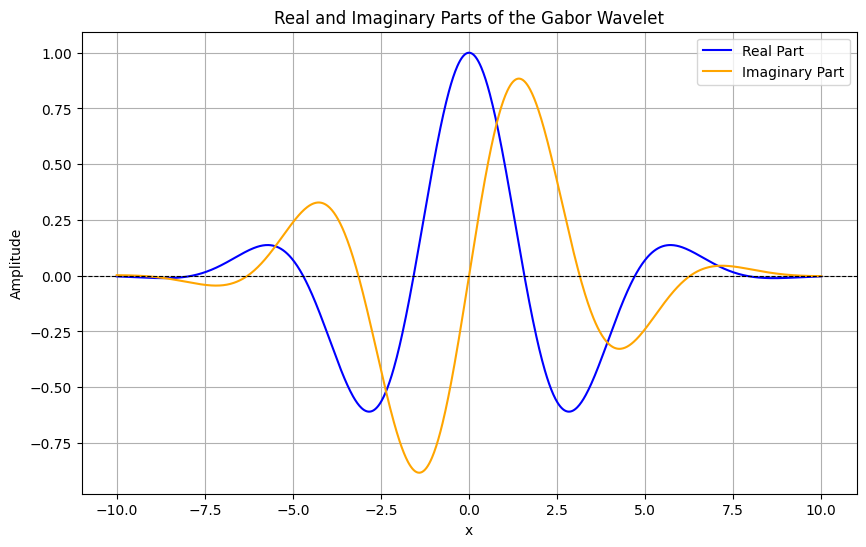

In [28]:
# Define the Gabor mother wavelet with real and imaginary parts
def gabor_wavelet(x, sigma=3, k=1):
    """
    Computes the real and imaginary parts of the Gabor wavelet.

    Parameters:
    x: array-like or float
        Input values for which the wavelet is computed.
    sigma: float
        Standard deviation of the Gaussian envelope (default: 3).
    k: float
        Frequency of the sinusoidal carrier wave (default: 1).

    Returns:
    real: array-like or float
        Real part of the Gabor wavelet.
    imag: array-like or float
        Imaginary part of the Gabor wavelet.
    """
    if sigma <= 0:
        raise ValueError("The parameter 'sigma' must be positive.")
    envelope = np.exp(-x**2 / (2 * sigma**2))
    real = envelope * np.cos(k * x)
    imag = envelope * np.sin(k * x)
    return real, imag

# Define the interval and parameters
x = np.linspace(-10, 10, 1000)
sigma = 3
k = 1

# Compute the real and imaginary parts of the Gabor wavelet
real_part, imag_part = gabor_wavelet(x, sigma=sigma, k=k)

# Plot the real and imaginary parts
plt.figure(figsize=(10, 6))
plt.plot(x, real_part, label="Real Part", color="blue")
plt.plot(x, imag_part, label="Imaginary Part", color="orange")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Real and Imaginary Parts of the Gabor Wavelet")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()


**Explanation**

The real part is computed using the Gaussian envelope multiplied by cos(𝑘𝑥).

The imaginary part is computed using the Gaussian envelope multiplied by sin(𝑘𝑥).

Both are plotted for the interval [−10,10] with 𝜎=3.

This plot shows how the real and imaginary components of the Gabor wavelet interact and decay within the Gaussian envelope. Let me know if you'd like further assistance!

**d)** Plot the real and imaginary part of the gabor wavelet in 3d. Use the Interval $\left[ -10, 10 \right]$ and $\sigma=3$.

The Gabor "mother" wavelet is a widely used wavelet with applications in signal processing and image analysis. It combines a Gaussian envelope with a sinusoidal carrier wave, which gives it its unique time-frequency localization properties. Mathematically, the Gabor wavelet can be expressed as:

$\psi(x) = \exp\left( - \frac{x^2}{2\sigma^2} \right) \cos(kx)$

Where:
𝜎: The standard deviation of the Gaussian envelope (controls the width of the wavelet).
𝑘: The frequency of the sinusoidal carrier wave.

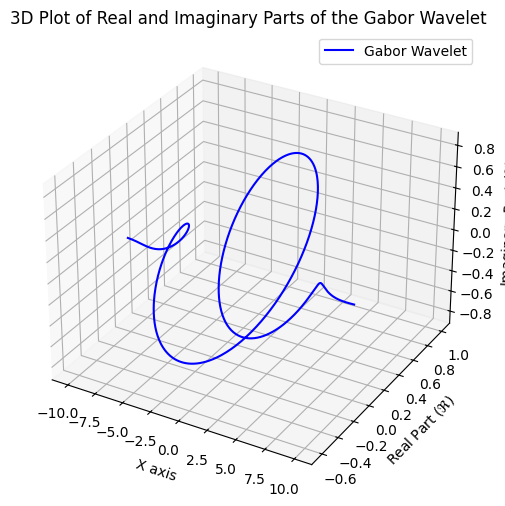

In [29]:
# Define the Gabor wavelet function with real and imaginary parts
def gabor_wavelet(x, sigma=3, k=1):
    """
    Computes the real and imaginary parts of the Gabor wavelet.

    Parameters:
    x: array-like or float
        Input values for which the wavelet is computed.
    sigma: float
        Standard deviation of the Gaussian envelope (default: 3).
    k: float
        Frequency of the sinusoidal carrier wave (default: 1).

    Returns:
    real: array-like or float
        Real part of the Gabor wavelet.
    imag: array-like or float
        Imaginary part of the Gabor wavelet.
    """
    if sigma <= 0:
        raise ValueError("The parameter 'sigma' must be positive.")
    envelope = np.exp(-x**2 / (2 * sigma**2))
    real = envelope * np.cos(k * x)
    imag = envelope * np.sin(k * x)
    return real, imag

# Define the interval and parameters
x = np.linspace(-10, 10, 1000)
sigma = 3
k = 1

# Compute the real and imaginary parts of the Gabor wavelet
real_part, imag_part = gabor_wavelet(x, sigma=sigma, k=k)

# Create the 3D plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection="3d")

# Plot the real and imaginary parts of the Gabor wavelet
ax.plot(x, real_part, imag_part, label="Gabor Wavelet", color="blue")

# Add labels and title
ax.set_xlabel("X axis")
ax.set_ylabel("Real Part ($\Re$)")
ax.set_zlabel("Imaginary Part ($\Im$)")
ax.set_title("3D Plot of Real and Imaginary Parts of the Gabor Wavelet")
ax.legend()
plt.show()


Explanation
Axes:

The 𝑥-axis represents the spatial domain.

The 𝑦-axis represents the real part (ℜ).

The 𝑧-axis represents the imaginary part (ℑ).

Visualization:

The curve in 3D space shows how the real and imaginary parts of the Gabor wavelet vary together, modulated by the Gaussian envelope.

**e)** Implement the Haar Basis Wavelet and the Haar Scale Wavelet.

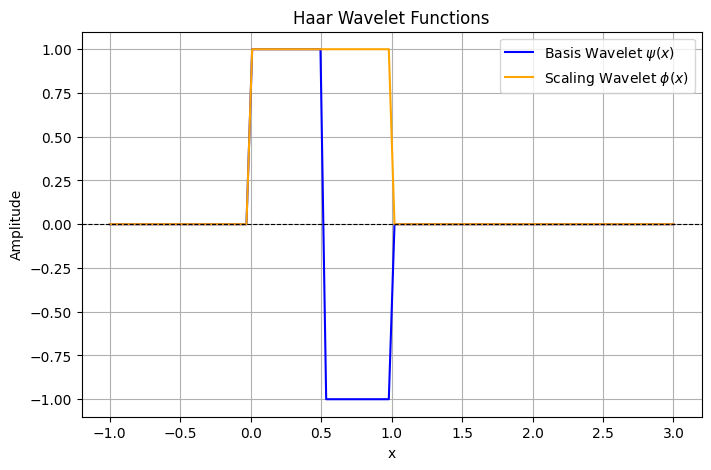

In [30]:
def haar_basis_wavelet(x):
    """
    Computes the Haar basis wavelet (ψ).

    Parameters:
    x: array-like
        Input values for which the Haar wavelet is computed.

    Returns:
    ret: array-like
        Haar basis wavelet values for the input x.
    """
    ret = np.zeros_like(x)
    ret[(x >= 0) & (x < 0.5)] = 1  # For 0 <= x < 0.5
    ret[(x >= 0.5) & (x < 1)] = -1  # For 0.5 <= x < 1
    return ret

def haar_scale_wavelet(x):
    """
    Computes the Haar scaling wavelet (φ).

    Parameters:
    x: array-like
        Input values for which the Haar scaling wavelet is computed.

    Returns:
    ret: array-like
        Haar scaling wavelet values for the input x.
    """
    ret = np.zeros_like(x)
    ret[(x >= 0) & (x < 1)] = 1  # For 0 <= x < 1
    return ret

# Generate values for x
x = np.linspace(-1, 3, 100)

# Plot Haar basis and scaling wavelets
plt.figure(figsize=(8, 5))
plt.grid()
plt.plot(x, haar_basis_wavelet(x), label="Basis Wavelet $\\psi(x)$", color="blue")
plt.plot(x, haar_scale_wavelet(x), label="Scaling Wavelet $\\phi(x)$", color="orange")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Haar Wavelet Functions")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


Explanation
Haar Basis Wavelet (𝜓(x)):

$\psi(x) =
\begin{cases}
1 & \text{if } 0 \leq x < 0.5 \\
-1 & \text{if } 0.5 \leq x < 1 \\
0 & \text{otherwise}
\end{cases}$


1. The wavelet alternates between +1 and −1 in two halves of the unit interval [0,1).
Haar Scale Wavelet (ϕ(x)):

2. The scaling function remains constant at +1 over the interval [0,1).

Plot:

The plot shows the basis and scaling wavelets clearly, demonstrating the piecewise constant nature of the Haar wavelets.
Let me know if further clarification or modifications are needed!